In [1]:
import os
cwd = os.getcwd()

# protection against running this cell multiple times
assert os.path.dirname(cwd).split('/')[-1] == 'master-thesis','Oops, directory already changed previously as indended. Ignoring...'

# change working directory (if assert passed)
new_cwd = os.path.dirname(cwd) # parent directory
os.chdir(new_cwd)

# Imports

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


import os
import json

from rnn_utils import DiagnosesDataset, split_dataset, MYCOLLATE
from rnn_utils import train_one_epoch, eval_model
from Logits2Predictions import Logits2Predictions

from mourga_variational.variational_rnn import VariationalRNN

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence, pack_sequence

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

idx = pd.IndexSlice

from config import Settings; settings = Settings()

# display all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


import os
import json

from rnn_utils import DiagnosesDataset, split_dataset, MYCOLLATE
from rnn_utils import train_one_epoch, eval_model
from Logits2Predictions import Logits2Predictions

from mourga_variational.variational_rnn import VariationalRNN

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence, pack_sequence

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

idx = pd.IndexSlice

from config import Settings; settings = Settings()

# display all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Parameters

In [2]:
experiment_id = 'A'

experiment_folder = os.path.join(settings.data_base,settings.variational_data_folder,experiment_id)
assert os.path.exists(experiment_folder),f'Experiment {experiment_id} data doesn\'t exist. You can create it with <CreateVariationalOutputs.ipynb>'

## Read outputs

In [3]:
var_path = os.path.join(experiment_folder,'variational_forward.csv')
det_path = os.path.join(experiment_folder,'deterministic_forward.csv')
golden_path = os.path.join(experiment_folder,'golden.csv')

df_var = pd.read_csv(var_path,index_col=[0,1,2])
df_det = pd.read_csv(det_path,index_col=[0,1])
df_golden = pd.read_csv(golden_path,index_col=[0,1])

df_var.head(2)
df_var.shape

df_det.head(2)
df_det.shape

df_golden.head(2)
df_golden.shape

diag_0    diag_1    diag_2    diag_3    diag_4  \
pat_id adm_index npass                                                     
21     1         1      0.001646  0.219600  0.087425  0.084163  0.026606   
                 2      0.001627  0.241448  0.127487  0.038899  0.002566   

                          diag_5    diag_6    diag_7    diag_8    diag_9  ...  \
pat_id adm_index npass                                                    ...   
21     1         1      0.029044  0.006477  0.005765  0.000793  0.014757  ...   
                 2      0.016236  0.004588  0.016988  0.000358  0.010856  ...   

                        diag_262  diag_263  diag_264  diag_265  diag_266  \
pat_id adm_index npass                                                     
21     1         1      0.000132  0.003995  0.000508  0.002002  0.046862   
                 2      0.000055  0.002041  0.000502  0.004578  0.077088   

                        diag_267  diag_268  diag_269  diag_270  diag_271  
pat_id adm_index npass                                                    
21     1         1      0.086731  0.001672  0.000341  0.001392  0.023608  
                 2      0.094556  0.001430  0.000183  0.001322  0.017402  

[2 rows x 272 columns]

(58290, 272)

,,diag_0,diag_1,diag_2,diag_3,diag_4,diag_5,diag_6,diag_7,diag_8,diag_9,...,diag_262,diag_263,diag_264,diag_265,diag_266,diag_267,diag_268,diag_269,diag_270,diag_271
pat_id,adm_index,,,,,,,,,,,,,,,,,,,,,
21,1,0.005465,0.281523,0.145583,0.050645,0.005677,0.007363,0.008749,0.007137,0.000349,0.012388,...,0.000104,0.003191,0.000439,0.010623,0.082972,0.117599,0.001562,0.000729,0.002455,0.027174
23,1,0.002017,0.127589,0.118386,0.019256,0.000759,0.001934,0.023269,0.003224,0.000435,0.013632,...,0.000307,0.000991,0.000544,0.005259,0.105743,0.056455,0.001037,0.000765,0.006583,0.019564


(1943, 272)

,,diag_0,diag_1,diag_2,diag_3,diag_4,diag_5,diag_6,diag_7,diag_8,diag_9,...,diag_262,diag_263,diag_264,diag_265,diag_266,diag_267,diag_268,diag_269,diag_270,diag_271
pat_id,adm_index,,,,,,,,,,,,,,,,,,,,,
21,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
23,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(1943, 272)

# get predictions

In [25]:
df_var_predictions = df_var.groupby(['pat_id','adm_index']).mean()

In [26]:
from sklearn.metrics import roc_curve
import warnings

def get_prediction_thresholds(prediction_data : pd.DataFrame, golden_data : pd.DataFrame, method='roc gm'):
    
    thresholds_data = None
    for diag in prediction_data.filter(like='diag_').columns:
        testy = golden_data.loc[:,diag].to_numpy().reshape((-1,1))
        yhat = prediction_data.loc[:,diag].to_numpy().reshape((-1,1))

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="No positive samples in y_true, true positive value should be meaningless")
            fpr, tpr, thresholds = roc_curve(testy, yhat);

        #geometric mean between sensitivity and specificity
        gmeans = np.sqrt(tpr * (1-fpr))

        # locate the index of the largest g-mean
        ix = np.argmax(gmeans)

        threshold = pd.DataFrame(data=[[thresholds[ix],gmeans[ix]]],columns=['threshold','gmean (roc)'],index=[diag])

        if thresholds_data is None:
            thresholds_data = threshold
        else:
            thresholds_data = pd.concat([thresholds_data,threshold])
    return thresholds_data

thresholds = get_prediction_thresholds(df_var_predictions,df_golden)
thresholds

,threshold,gmean (roc)
diag_0,0.001976,0.768232
diag_1,0.188345,0.641276
diag_2,0.129781,0.586007
diag_3,0.050180,0.633603
diag_4,0.340341,0.999215
...,...,...
diag_267,0.101361,0.585618
diag_268,0.009143,0.738998
diag_269,0.001331,0.736549
diag_270,0.004743,0.603884


In [27]:
def predict(predictions: pd.Series, threshold : float):
    return predictions.apply(lambda x: 1 if x > threshold else 0)

predictions = df_var_predictions.apply(lambda x: predict(x,thresholds.loc[x.name,'threshold']),axis=0)

predictions.head(3)

,,diag_0,diag_1,diag_2,diag_3,diag_4,diag_5,diag_6,diag_7,diag_8,diag_9,...,diag_262,diag_263,diag_264,diag_265,diag_266,diag_267,diag_268,diag_269,diag_270,diag_271
pat_id,adm_index,,,,,,,,,,,,,,,,,,,,,
21,1,1,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
23,1,0,0,0,0,0,0,1,0,1,0,...,1,0,0,0,0,0,0,0,1,0
61,1,1,1,0,1,0,0,1,1,1,1,...,1,0,0,1,1,1,0,1,0,1


# Reliability diagram

In [28]:
diag = 'diag_88'
diagnostic_preds = predictions.loc[:,diag]
diagnostic_logits = df_var_predictions.loc[:,diag]
diagnostic_goldens = df_golden.loc[:,diag]

In [32]:
output_probabilities = (diagnostic_logits
                     .copy()
                     .to_frame('positive_class')
                     .assign(negative_class=lambda x: 1-x.positive_class)
                    )[['negative_class','positive_class']]

#predictions = np.argmax(output_probabilities.to_numpy(),axis=1)
predictions = diagnostic_preds.to_numpy()
#confidences = np.max(output_probabilities.to_numpy(),axis=1)
confidences = output_probabilities.apply(lambda row: row.iloc[diagnostic_preds.loc[row.name]], axis=1)
accuracies = predictions == diagnostic_goldens.to_numpy()

nbins = 10
bins = np.linspace(0,1,nbins+1)
bins_left = bins[:-1]
bins_right = bins[1:]

acc_in_bin_list = list()
for left,right in zip(bins_left,bins_right):
    in_bin = (confidences > left) & (confidences < right)
    prop_in_bin = in_bin.mean()
    
    if prop_in_bin > 0:
        acc_in_bin_list.append(accuracies[in_bin].mean())
    else:
        acc_in_bin_list.append(0)


In [40]:
def plot_conf(acc, conf):
    fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.25))
    ax.plot([0,1], [0,1], 'k--')
    ax.plot(conf, acc, marker='.')
    ax.set_xlabel(r'confidence')
    ax.set_ylabel(r'accuracy')
    ax.set_xticks((np.arange(0, 1.1, step=0.2)))
    ax.set_yticks((np.arange(0, 1.1, step=0.2)))

    return fig, ax

In [38]:
bins

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

(<Figure size 180x162 with 1 Axes>,
 <AxesSubplot:xlabel='confidence', ylabel='accuracy'>)

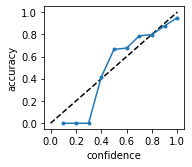

In [41]:
plot_conf(acc_in_bin_list, bins[1:])

In [ ]:
def acc_vs_conf():
    

In [7]:
diag = 'diag_88'
diagnostic_preds = predictions.loc[:,diag]
diagnostic_logits = df_var_predictions.loc[:,diag]
diagnostic_goldens = df_golden.loc[:,diag]
nbins = 10
uce, entropy_in_bin, errors_in_bin = UCE(diagnostic_preds,diagnostic_logits,diagnostic_goldens,nbins=nbins)

NameError: name 'UCE' is not defined

In [32]:
errors_in_bin

[0.017391304347826087,
 0.025,
 0.04145077720207254,
 0.0962566844919786,
 0.08994708994708994,
 0.10576923076923077,
 0.19402985074626866,
 0.2191780821917808,
 0.3481953290870488]

In [89]:
def ECE(diagnostic_preds : pd.Series,diagnostic_logits: pd.Series, diagnostic_goldens : pd.Series, nbins:int = 11):
    """
    Computes the Expected Uncertainty Calibration error for a batch of predictions of a single diagnosis.
    """
    
    # output distribution of sigmoid
    output_probabilities = (diagnostic_logits
                     .copy()
                     .to_frame('positive_class')
                     .assign(negative_class=lambda x: 1-x.positive_class)
                    )
    
    bins = np.linspace(0,1,num=nbins)
    idxbins = np.digitize(diagnostic_logits,bins,right=True)
    
    acc_list = list()
    
    for b in range(1,nbins):
        mask = np.where(idxbins==b)[0]
        if len(mask) == 0:
            print(f'oops: {b}')
        
        acc = diagnostic_goldens.iloc[mask].mean()
        acc_list.append(acc)
    return {'acc_list':acc_list,'nbins':nbins,'idxbins':idxbins}



diag = 'diag_88'
diagnostic_preds = predictions.loc[:,diag]
diagnostic_logits = df_var_predictions.loc[:,diag]
diagnostic_goldens = df_golden.loc[:,diag]
nbins = 10

res = ECE(diagnostic_preds,diagnostic_logits,diagnostic_goldens)

acc_list = res['acc_list']
nbins=res['nbins']
        

In [96]:
acc_list

[0.04675716440422323,
 0.1339031339031339,
 0.23699421965317918,
 0.392,
 0.6639344262295082,
 0.6761904761904762,
 0.7925925925925926,
 0.8467741935483871,
 0.908256880733945,
 0.8888888888888888]

<BarContainer object of 10 artists>

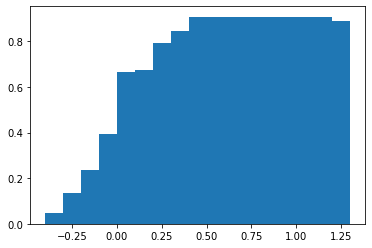

In [94]:
plt.bar(bins[:-1],acc_list)

In [85]:
bins = np.linspace(0,1,num=11)
idxbins = np.digitize(diagnostic_logits,bins,right=True)

In [88]:
bins

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [64]:
idxbins.nunique()

AttributeError: 'numpy.ndarray' object has no attribute 'nunique'

In [ ]:
for b in range(1,bins+1)

In [61]:
pd.Series(idxbins).value_counts()

1    715
2    342
3    169
6    140
4    137
7    136
8    131
5    130
9     43
dtype: int64

In [56]:
diagnostic_logits.max()

0.9786105793333333

In [54]:
acc_list

[0.9496503496503497,
 0.8421052631578947,
 0.7337278106508875,
 0.45985401459854014,
 0.6846153846153846,
 0.7785714285714286,
 0.8308823529411765,
 0.8931297709923665,
 0.9069767441860465,
 nan]

In [51]:
diagnostic_preds

pat_id  adm_index
21      1            1
23      1            1
61      1            0
94      1            0
105     1            0
                    ..
99383   3            0
99650   1            1
        2            1
99756   1            0
        2            0
Name: diag_88, Length: 1943, dtype: int64

In [50]:
diagnostic_logits.iloc[(res['idxbins'] == 1)]

pat_id  adm_index
61      1            0.019892
105     1            0.099739
109     16           0.101904
        24           0.087280
        27           0.106498
                       ...   
98864   1            0.081643
98930   1            0.090641
99383   1            0.069421
99756   1            0.047034
        2            0.046286
Name: diag_88, Length: 715, dtype: float64

In [ ]:
def ECE(diagnostic_preds : pd.Series,diagnostic_logits: pd.Series, diagnostic_goldens : pd.Series, nbins:int = 10):
    """
    Computes the Expected Uncertainty Calibration error for a batch of predictions of a single diagnosis.
    """
    
    # output distribution of sigmoid
    output_probabilities = (diagnostic_logits
                     .copy()
                     .to_frame('positive_class')
                     .assign(negative_class=lambda x: 1-x.positive_class)
                    )
    
    errors = diagnostic_preds != diagnostic_goldens
    acc
    
    ece = 0
    avg_acc_in_bin_list = []
    #errors_in_bin_list = []
    
    bins = np.linspace(0,1,num=nbins)
    idxbins = np.digitize(entropies,bins,right=True)
    for b in range(1,nbins+1):
        idx = np.where(idxbins==b)[0]
        
        if len(idx) == 0:
            # no uncertainties in this bin
            continue
            
        errors_in_bin = errors.iloc[idx].mean()
        avg_entropy_in_bin = entropies.iloc[idx].mean()
        prop_in_bin = len(idx)/len(idxbins) # Bm / n
        
        uce += np.abs(avg_entropy_in_bin - errors_in_bin) * prop_in_bin
        
        avg_enropy_in_bin_list.append(avg_entropy_in_bin)
        errors_in_bin_list.append(errors_in_bin)
        
    return uce, avg_enropy_in_bin_list, errors_in_bin_list

In [6]:
def UCE(diagnostic_preds : pd.Series,diagnostic_logits: pd.Series, diagnostic_goldens : pd.Series, nbins:int = 10):
    """
    Computes the Expected Uncertainty Calibration error for a batch of predictions of a single diagnosis.
    """
    
    # output distribution of sigmoid
    output_probabilities = (diagnostic_logits
                     .copy()
                     .to_frame('positive_class')
                     .assign(negative_class=lambda x: 1-x.positive_class)
                    )
    # compute entropies
    entropy_calc = lambda row: -1 * sum([e * np.log2(e) for e in row])
    entropies = output_probabilities.apply(entropy_calc,axis=1)
    
    
    errors = diagnostic_preds != diagnostic_goldens
    
    uce = 0
    avg_enropy_in_bin_list = []
    errors_in_bin_list = []
    
    bins = np.linspace(0,1,num=nbins)
    idxbins = np.digitize(entropies,bins,right=True)
    for b in range(1,nbins+1):
        idx = np.where(idxbins==b)[0]
        
        if len(idx) == 0:
            # no uncertainties in this bin
            continue
            
        errors_in_bin = errors.iloc[idx].mean()
        avg_entropy_in_bin = entropies.iloc[idx].mean()
        prop_in_bin = len(idx)/len(idxbins) # Bm / n
        
        uce += np.abs(avg_entropy_in_bin - errors_in_bin) * prop_in_bin
        
        avg_enropy_in_bin_list.append(avg_entropy_in_bin)
        errors_in_bin_list.append(errors_in_bin)
        
    return uce, avg_enropy_in_bin_list, errors_in_bin_list

how do i test this?

- look at one diagnosis only.
- 
